In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Assumes notebook is inside: capstone_project_unfc/model/notebooks
REPO_ROOT = Path.cwd().parent.parent
ART = REPO_ROOT / "model" / "notebooks" / "artifacts"

print("Repo root:", REPO_ROOT)
print("Artifacts folder:", ART)
print("Exists:", ART.exists())

Repo root: c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc
Artifacts folder: c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\model\notebooks\artifacts
Exists: True


In [3]:
FILES = {
    "Baseline (EWM)": "pred_baseline_weekly_price.parquet",
    "Prophet": "pred_prophet_weekly_price.parquet",
    "LSTM": "pred_lstm_weekly_price.parquet",
    "XGBoost": "pred_xgb_weekly_price.parquet",
}

missing = [fname for fname in FILES.values() if not (ART / fname).exists()]
if missing:
    print("❌ Missing prediction files:")
    for m in missing:
        print("  -", m)
    raise FileNotFoundError(
        "Create/save these prediction parquet files first (in each model notebook), "
        "then rerun this shootout notebook."
    )

print("✅ All prediction files found.")

✅ All prediction files found.


In [4]:
def load_pred(path: Path) -> pd.DataFrame:
    df = pd.read_parquet(path).copy()
    if "timestamp" not in df.columns:
        raise ValueError(f"{path.name} must contain a 'timestamp' column.")
    if not {"y_true", "y_pred"}.issubset(df.columns):
        raise ValueError(f"{path.name} must contain 'y_true' and 'y_pred' columns.")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").set_index("timestamp")
    df = df[["y_true", "y_pred"]]
    return df

preds = {}
for model_name, fname in FILES.items():
    preds[model_name] = load_pred(ART / fname)

# quick peek
{m: (df.shape, df.index.min(), df.index.max()) for m, df in preds.items()}

{'Baseline (EWM)': ((30, 2),
  Timestamp('2025-07-28 00:00:00+0000', tz='UTC'),
  Timestamp('2026-02-16 00:00:00+0000', tz='UTC')),
 'Prophet': ((30, 2),
  Timestamp('2025-07-28 00:00:00+0000', tz='UTC'),
  Timestamp('2026-02-16 00:00:00+0000', tz='UTC')),
 'LSTM': ((30, 2),
  Timestamp('2025-07-28 00:00:00+0000', tz='UTC'),
  Timestamp('2026-02-16 00:00:00+0000', tz='UTC')),
 'XGBoost': ((30, 2),
  Timestamp('2025-07-21 00:00:00+0000', tz='UTC'),
  Timestamp('2026-02-09 00:00:00+0000', tz='UTC'))}

In [5]:
common_index = None
for df in preds.values():
    common_index = df.index if common_index is None else common_index.intersection(df.index)

if len(common_index) == 0:
    raise ValueError("No overlapping timestamps found across all models.")

print("Common evaluation points:", len(common_index))
print("Common range:", common_index.min(), "→", common_index.max())

preds_aligned = {m: df.loc[common_index].copy() for m, df in preds.items()}

# Sanity: y_true should match across models now
y_true_ref = preds_aligned[list(preds_aligned.keys())[0]]["y_true"]
for m, df in preds_aligned.items():
    if not np.allclose(df["y_true"].values, y_true_ref.values, rtol=1e-9, atol=1e-9):
        print("⚠️ Warning: y_true differs for model:", m)

Common evaluation points: 29
Common range: 2025-07-28 00:00:00+00:00 → 2026-02-09 00:00:00+00:00
⚠️ Warning: y_true differs for model: XGBoost


In [6]:
from math import sqrt

def compute_metrics(df: pd.DataFrame) -> dict:
    y = df["y_true"].to_numpy(dtype=float)
    yhat = df["y_pred"].to_numpy(dtype=float)

    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat)**2))

    # Avoid divide-by-zero issues in MAPE (not expected for BTC, but safe)
    denom = np.where(np.abs(y) < 1e-12, np.nan, y)
    mape = np.nanmean(np.abs((y - yhat) / denom)) * 100

    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

rows = []
for m, df in preds_aligned.items():
    rows.append({"Model": m, **compute_metrics(df)})

results = pd.DataFrame(rows).set_index("Model").sort_values("RMSE")
results

,MAE,RMSE,MAPE_%
Model,,,
XGBoost,6939.723599,9326.544159,7.419660
Baseline (EWM),10619.075246,12622.796160,11.720359
LSTM,12335.214702,14772.716861,13.013119
Prophet,20198.720125,24770.870728,22.889187


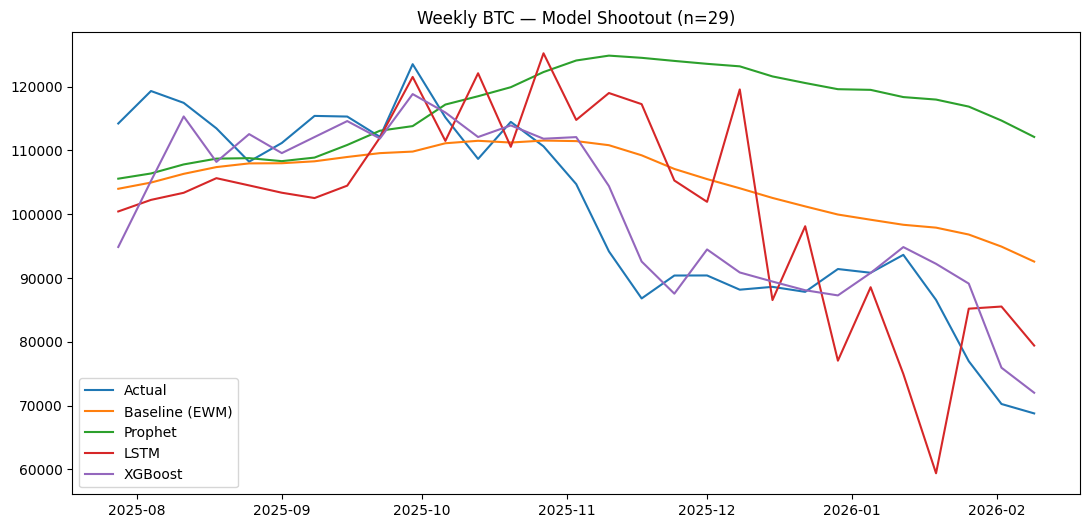

In [ ]:
# Build a single plotting frame
plot_df = pd.DataFrame(index=common_index)
plot_df["Actual"] = y_true_ref.values

for m, df in preds_aligned.items():
    plot_df[m] = df["y_pred"].values

plt.figure(figsize=(13, 6))
plt.plot(plot_df.index, plot_df["Actual"], label="Actual")

for m in preds_aligned.keys():
    plt.plot(plot_df.index, plot_df[m], label=m)

plt.title(f"Weekly BTC — Model Shootout (n={len(plot_df)})")
plt.legend()
plt.show()